# Mackey-Glass autoregression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import water_tank as wt

The Mackey-Glass equations are delay differential equations that exhibit chaotic behavior, i.e. they cannot be predict accurately for a long period of time.

$$\frac{d x(t)}{dt} = \beta \, \frac{x(t - \tau)}{1 + x(t - \tau)^n} - \gamma \, x(t)$$

To check this, we use `reservoirpy` (<https://reservoirpy.readthedocs.io>) to generate two time series with very close initial conditions ($\epsilon = 10^{-6}$). After roughly two seconds of simulation, the two time series start to diverge.

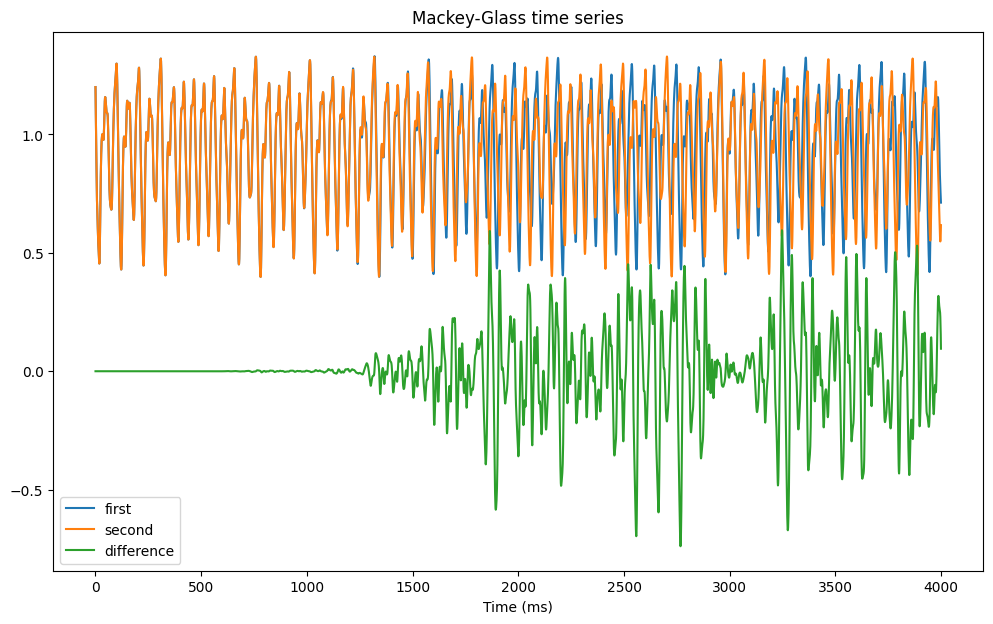

In [2]:
from reservoirpy.datasets import mackey_glass

mg1 = mackey_glass(4000, x0=1.2)
mg2 = mackey_glass(4000, x0=1.2 + 1e-6)

plt.figure(figsize=(12, 7))
plt.plot(mg1, label="first")
plt.plot(mg2, label="second")
plt.plot(mg1 - mg2, label="difference")
plt.legend()
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

For the autoregression task, we generate a time series, normalize it and create supervised targets to predict the value of the signal at time $t + 1$ given the past. 

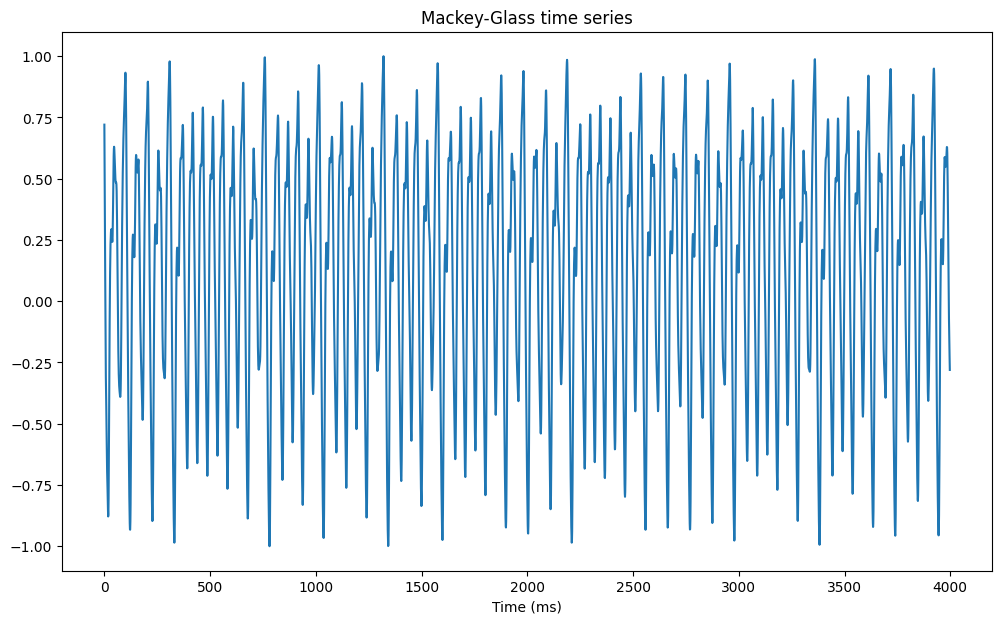

In [3]:
# Generate time series
mg = mackey_glass(4000, x0=1.2)

# Normalize between -1 and 1
mg =  2.0 * (mg - mg.min()) / (mg.max() - mg.min()) - 1.0

# The task is to predict the next value
X = mg[:-1, 0]
Y = mg[1:, 0]

plt.figure(figsize=(12, 7))
plt.plot(X)
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

## Using water-tank

We now create an echo-state network with:

* an input layer with one neuron
* a reservoir with $N$ tanh neurons.
* a readout layer with one neuron.

The weight matrices are initialized classically. Note that the recurrent and readout neurons both use biases. The readout weights are trained online using the **recursive least squares** (RLS) method. 

Two methods are implemented in the class: a training method calling the learning rule, and an autoregressive method plugging the output of the networks back into its input. 

In [4]:
class ESN(object):

    def __init__(self, N, N_in, N_out, g, tau, sparseness):

        # Input population
        self.inp = wt.layers.StaticInput(size=N_in)

        # Reservoir 
        self.rc = wt.layers.RecurrentLayer(size=N, tau=tau)

        # Readout
        self.readout = wt.layers.LinearReadout(size=N_out)

        # Input projection
        self.inp_proj = wt.connect(
            pre = self.inp, 
            post = self.rc, 
            weights = wt.random.Bernouilli([-1.0, 1.0], p=0.5), 
            bias = None,
            sparseness = 0.1
        )

        # Recurrent projection
        self.rec_proj = wt.connect(
            pre = self.rc, 
            post = self.rc, 
            weights = wt.random.Normal(0.0, g/np.sqrt(sparseness*N)), 
            bias = wt.random.Bernouilli([-1.0, 1.0], p=0.5), # very important
            sparseness = sparseness
        )

        # Readout projection
        self.readout_proj = wt.connect(
            pre = self.rc, 
            post = self.readout,
            weights = wt.random.Const(0.0),
            bias = wt.random.Const(0.0), # learnable bias
            sparseness = 1.0 # readout should be dense
        )

        # Learning rules
        self.learningrule = wt.rules.RLS(
            projection=self.readout_proj, 
            delta=1e-6
        )

        # Recorder
        self.recorder = wt.Recorder()

    @wt.measure
    def train(self, X, Y, warmup=0):

        for t, (x, y) in enumerate(zip(X, Y)): 

            # Inputs/targets
            self.inp.set(x)

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Learning
            if t >= warmup: 
                self.learningrule.train(
                    error = y - self.readout.output()
                )

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output(),
            })
    
    @wt.measure
    def autoregressive(self, duration):

        for _ in range(duration): 
            # Autoregressive input
            self.inp.set(self.readout.output())  

            # Steps 
            self.rc.step() 
            self.readout.step()

            # Recording
            self.recorder.record({
                'rc': self.rc.output(), 
                'readout': self.readout.output()
            })

In [5]:
N_in = 1 # number of inputs
N_out = 1 # number of outputs
N = 200 # number of neurons
g = 1.25 # scaling factor
tau = 3.3 # time constant
sparseness = 0.1 # sparseness of the recurrent weights

net = ESN(N, N_in, N_out, g, tau, sparseness)

We train the reservoir for 500 time steps and let it predict the signal autoregressively for 1000 steps.

In [6]:
# Training / test
d_train = 500
d_test = 1000

# Supervised training
net.train(X[:d_train], Y[:d_train], warmup=0)

# Autoregressive test
net.autoregressive(duration=d_test)

data = net.recorder.get()

Execution time: 213 ms
Execution time: 39 ms


The training error becomes quickly very small. When predicting the time series autoregressively, the predictions are precise for around 200 steps, before starting to diverge. 

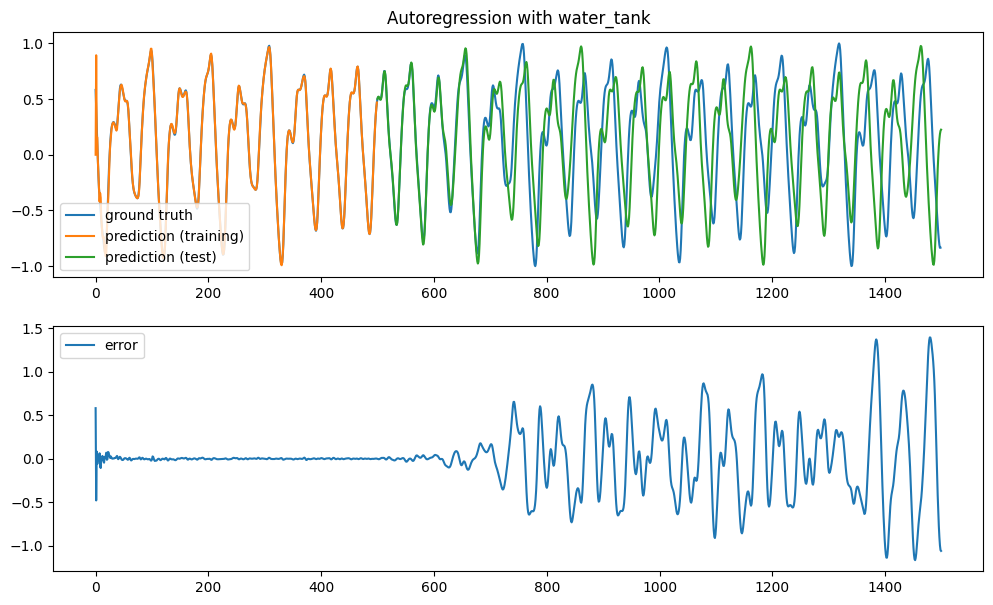

In [7]:
plt.figure(figsize=(12, 7))
plt.subplot(211)
plt.title("Autoregression with water_tank")
plt.plot(Y[:d_train+d_test], label='ground truth')
plt.plot(data['readout'][:d_train], label='prediction (training)')
plt.plot(np.linspace(d_train, d_train+d_test, d_test), data['readout'][d_train:], label='prediction (test)')
plt.legend()
plt.subplot(212)
plt.plot(Y[:d_train+d_test] - data['readout'][:], label='error')
plt.legend()
plt.show()

It is interesting to note that, for the autoregression to work correctly, the input biases are critical. They have the effect that many reservoir neurons are saturated (+1 or -1) and only a few are in the "useful" region and change their sign.

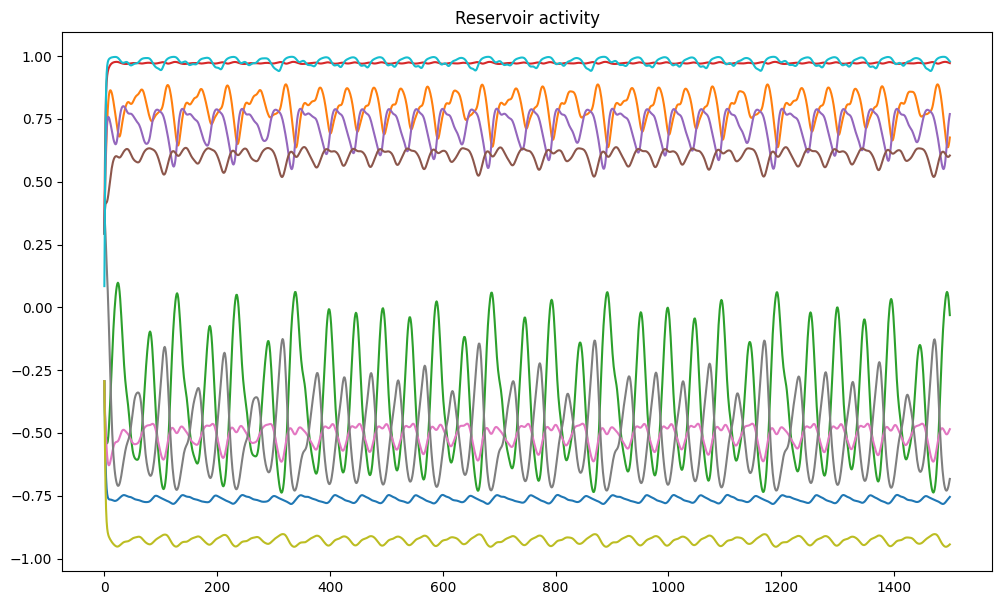

In [8]:
plt.figure(figsize=(12, 7))
plt.title("Reservoir activity")
for i in range(10):
    plt.plot(data['rc'][:, i])
plt.show()

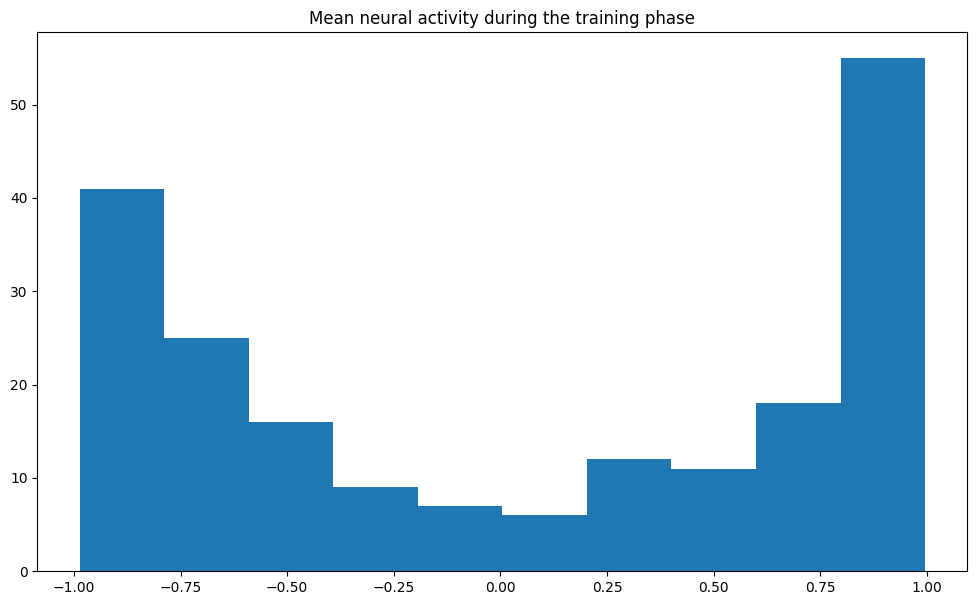

In [9]:
mean_act = data['rc'].mean(axis=0)

plt.figure(figsize=(12, 7))
plt.title("Mean neural activity during the training phase")
plt.hist(mean_act)
plt.show()

When plotting the readout weights after training, we can see that saturated neurons whose activity is very close to +1 or -1 throughout learning tend to get smaller readout weights. This is an effect of the inverse correlation matrix used in RLS: if the pre neuron is not significantly active, it should not participate to the output. 

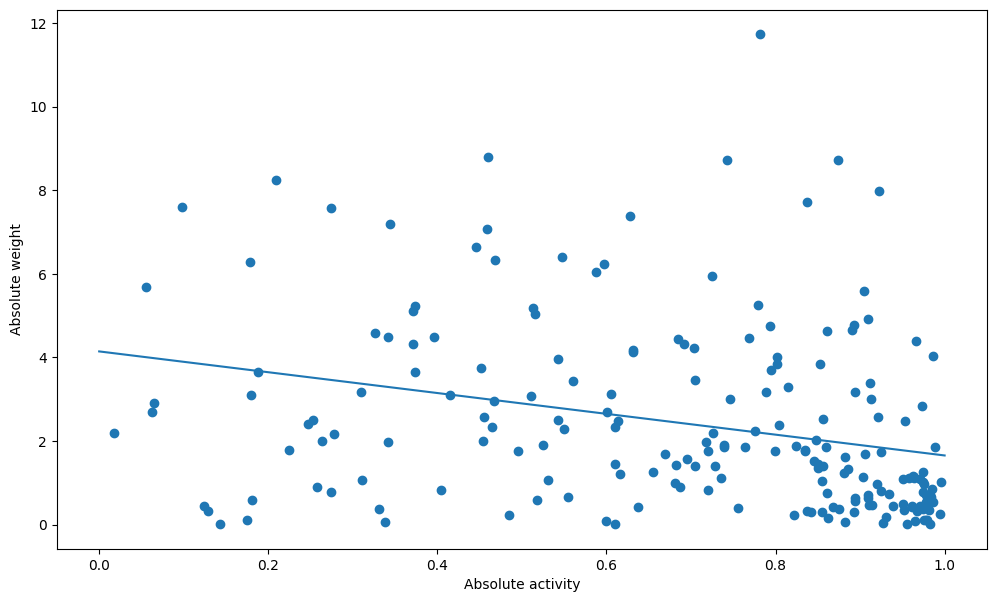

In [10]:
from sklearn.linear_model import LinearRegression
x = np.abs(mean_act).reshape((N, 1))
t = np.abs(net.readout_proj.W[0, :]).reshape((N, 1))
reg = LinearRegression().fit(x, t)
y = reg.predict([[0], [1]])

plt.figure(figsize=(12, 7))
plt.scatter(x, t)
plt.plot([0, 1], y)
plt.xlabel("Absolute activity")
plt.ylabel("Absolute weight")
plt.show()

# Using reservoirpy

For the sake of comparison, let's see how the same problem is addressed by reservoirpy.

Running Model-0: 100%|██████████| 1/1 [00:00<00:00, 5489.93it/s]


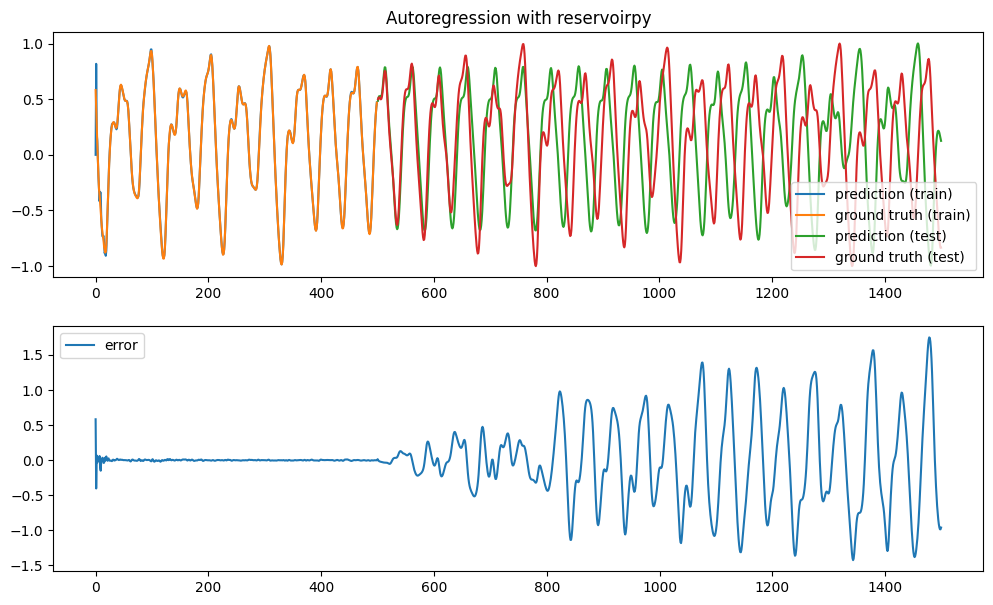

In [11]:
from reservoirpy.nodes import Reservoir, RLS
from reservoirpy.datasets import mackey_glass

# Mackey-Glass chaotic time series
X = mackey_glass(n_timesteps=2000)
X =  2.0 * (X - X.min()) / (X.max() - X.min()) - 1.0

# Create the reservoir with RLS online learning
reservoir = Reservoir(units=200, lr=0.3, sr=1.25)
readout = RLS(output_dim=1)
esn = reservoir >> readout

# Train / test
d_train = 500
d_test = 1000

# Supervised training
training = esn.train(X[:d_train], X[1:1+d_train])

# Autoregression
predictions = []
errors = list(X[1:1+d_train] - training)
pred = [X[d_train-1]]
for t in range(d_test):
    pred = esn.run(pred)
    predictions.append(pred[0])
    errors.append(X[d_train + t + 1, 0] - pred[0])

plt.figure(figsize=(12, 7))
plt.subplot(211)
plt.title("Autoregression with reservoirpy")
plt.plot(training, label='prediction (train)')
plt.plot(X[1:1+d_train], label='ground truth (train)')
plt.plot(np.arange(1+d_train, 1+d_train+d_test), predictions, label='prediction (test)')
plt.plot(np.arange(1+d_train, 1+d_train+d_test), X[1+d_train: 1+d_train+d_test, 0], label='ground truth (test)')
plt.legend()
plt.subplot(212)
plt.plot(errors, label='error')
plt.legend()
plt.show()